# Sign Language Recognition

## Importing Libraries / Setup / Variables


In [2]:
import random
import numpy as np
from torch import nn
from torch import torch
import sys
sys.path.insert(1, 'src/')

# Setup Device to run on
device = "cuda" if torch.cuda.is_available() else "cpu"

# Size and number of classes
input_size = 784
num_classes = 26

# Hyperparameters
learning_rate = 0.001
batch_size = 64
num_epochs = 7

# model settings
load_model = True
model_name = "small_but_good.pth"

# Set seeds for reproducibility
seed = 27
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# Label map
labels_map = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
    5: "F",
    6: "G",
    7: "H",
    8: "I",
    9: "J", # Does not exist in this dataset as it is a moving sign
    10: "K",
    11: "L",
    12: "M",
    13: "N",
    14: "O",
    15: "P",
    16: "Q",
    17: "R",
    18: "S",
    19: "T",
    20: "U",
    21: "V",
    22: "W",
    23: "X",
    24: "Y",
    25: "Z", # Does not exist in this dataset as it is a moving sign
}
# See the folder dataset for more information on the dataset and a cheat sheet for the labels

## Creating the CNN

Using convolution layers to create filters that detect what kind of sign it should be. Decided against pooling as 28x28 aren't a lot of pixel and information will be lost decreasing this too much. Also using Dropout to prevent over-fitting, but it still seems to over-fit a lot.


In [3]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        super(CNN, self).__init__()
        # First convolutional layer: 1 input channel, 8 output channels, 3x3 kernel, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        # Max pooling layer: 2x2 window, stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer: 8 input channels, 16 output channels, 3x3 kernel, stride 1, padding 1
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        # Fully connected layer: 16*7*7 input features (after two 2x2 poolings), 10 output features (num_classes)
        self.linearLayer1 = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool(x)
        x = self.relu2(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.linearLayer1(x)
        return x


model = CNN(in_channels=1, num_classes=num_classes).to(device)

## Different CNN Models and their results


## Loading Data

We are using the AutoAugment technique for our dataset, which applies a predefined policy to enhance the training dataset. The default policy, IMAGENET, consists of multiple sub-policies that emulate augmentations effective for similar datasets. Each sub-policy combines various transformations, such as rotation, color jitter, or flipping, to introduce diverse variations and improve model generalization.

This made our model a lot better and seems like it isn't over-fitting anymore.

More information on AutoAugment [here](https://arxiv.org/pdf/1805.09501)

We then load the CSV and set up a dataLoader.

Dataset from Kaggle: [Sign Language MNIST](https://www.kaggle.com/datasets/datamunge/sign-language-mnist)

License: [CC0: Public Domain](https://creativecommons.org/publicdomain/zero/1.0/)

See the folder `dataset` for pictures on the dataset and their labels.


In [4]:
from torchvision.transforms import v2
from load import ImageDataset
from torch.utils.data import DataLoader

transforms = v2.Compose(
    [
        # v2.RandomRotation(10),
        # v2.RandomHorizontalFlip(),
        # v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        # v2.RandomResizedCrop(28, scale=(0.9, 1.1)),
        v2.AutoAugment(),
    ]
)

csv_file_train = "dataset/sign_mnist_train/sign_mnist_train.csv"
csv_file_test = "dataset/sign_mnist_test/sign_mnist_test.csv"
dataset_train = ImageDataset(csv_file_train, transform=transforms)
dataset_test = ImageDataset(csv_file_test)

train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True)

## Function to evaluate model


In [5]:
def check_accuracy(loader, model, train):
    if train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        accuracy = float(num_correct) / float(num_samples) * 100
        print(f"Got {num_correct}/{num_samples} with accuracy {accuracy:.2f}%")
    model.train()

## Load model


In [6]:
if load_model == True:
    model.load_state_dict(torch.load("saved_models/" + model_name))
    print(f"Model: {model} loaded from file")

Model: CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (linearLayer1): Linear(in_features=784, out_features=26, bias=True)
) loaded from file


/var/folders/s3/vf1x2r0x5p7cxm_snmfd4lp40000gn/T/ipykernel_1936/150856649.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("saved_models/

## Train and save model


In [7]:
from torch import optim
from tqdm import tqdm

if not load_model:
    print(f"Model: {model}")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch + 1}/{num_epochs}]")

        for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
            data = data.to(device)
            targets = targets.to(device)

            # Forward pass
            scores = model(data)
            loss = criterion(scores, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        check_accuracy(train_loader, model, train=True)
        check_accuracy(test_loader, model, train=False)

    torch.save(model.state_dict(), "saved_models/tmp.pth")

## Evaluate model


In [8]:
check_accuracy(train_loader, model, train=True)
check_accuracy(test_loader, model, train=False)

Checking accuracy on training data
Got 25309/27455 with accuracy 92.18%
Checking accuracy on test data
Got 6513/7172 with accuracy 90.81%


### Model Evaluation Results
During the project, different model designs were used. They are described here:

#### **Model 1:** (implemented above)

**Hyperparams:**
`learning_rate = 0.001
batch_size = 64
num_epochs = 7 `

```python
CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (linearLayer1): Linear(in_features=784, out_features=26, bias=True)
)
```

| Dataset      | Correct Predictions | Total Samples | Accuracy |
| ------------ | ------------------- | ------------- | -------- |
| **Training** | 25,309              | 27,455        | 92.18%   |
| **Test**     | 6,513               | 7,172         | 90.81%   |

- **Training Accuracy:** 92.18%
- **Test Accuracy:** 90.81%

#### **Model 2:** `model_auto_augment_mac.pth`

**Hyperparams:** `learning_rate = 0.001
batch_size = 64
num_epochs = 7 `

```python
CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100352, out_features=64, bias=True)
  (relu5): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=26, bias=True)
)
```

| Dataset      | Correct Predictions | Total Samples | Accuracy |
| ------------ | ------------------- | ------------- | -------- |
| **Training** | 26,208              | 27,455        | 95.46%   |
| **Test**     | 6,340               | 7,172         | 88.40%   |

- **Training Accuracy:** 95.46%
- **Test Accuracy:** 88.40%

Notes:

- Probably 4/5 Epochs are enough
- Takes a long time to train roughly 13 min on mac
- Complex and deep model


## Analyze results with Gradcam


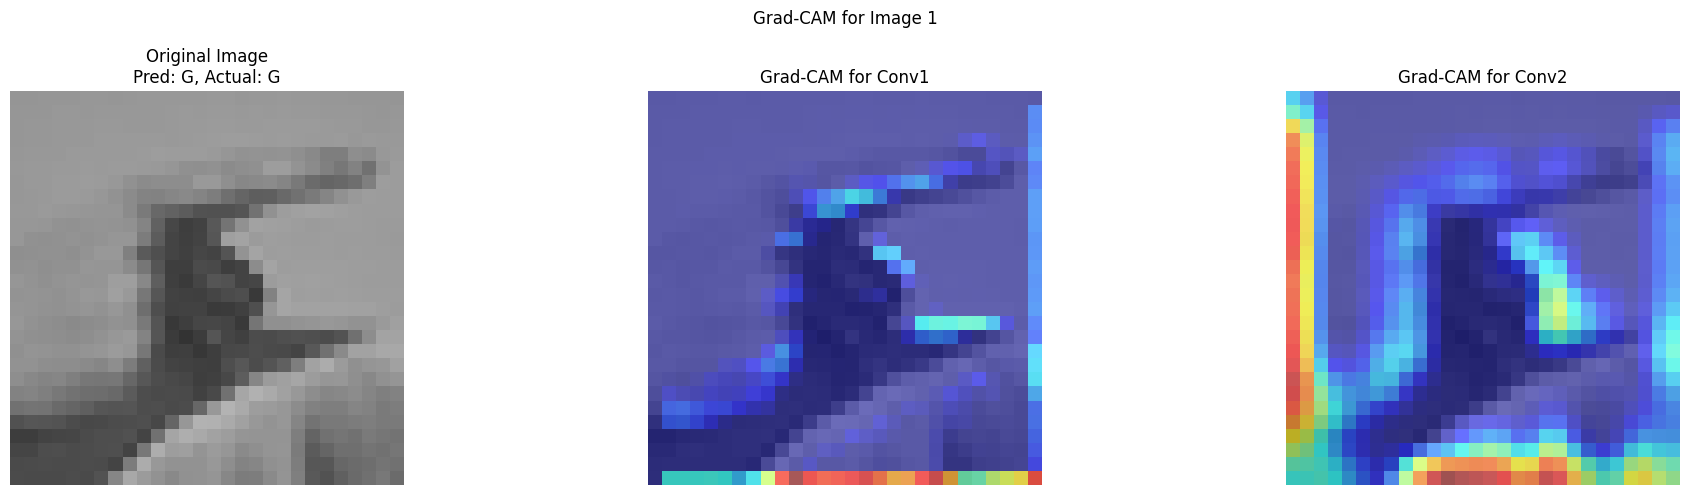

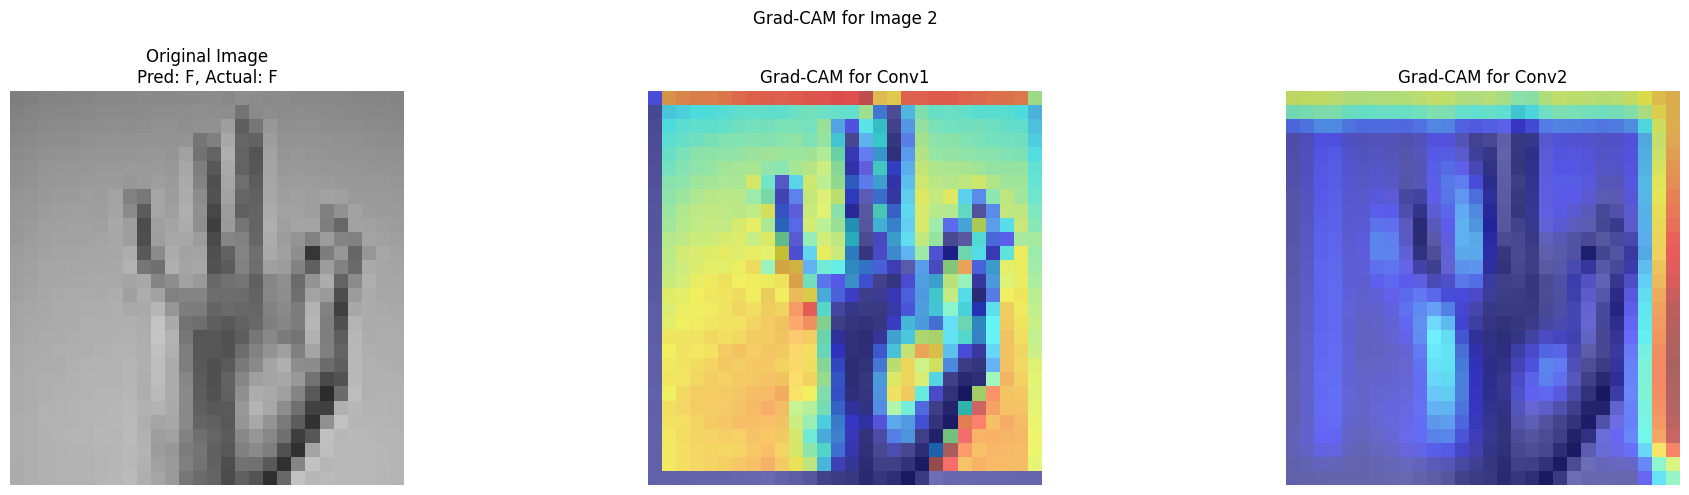

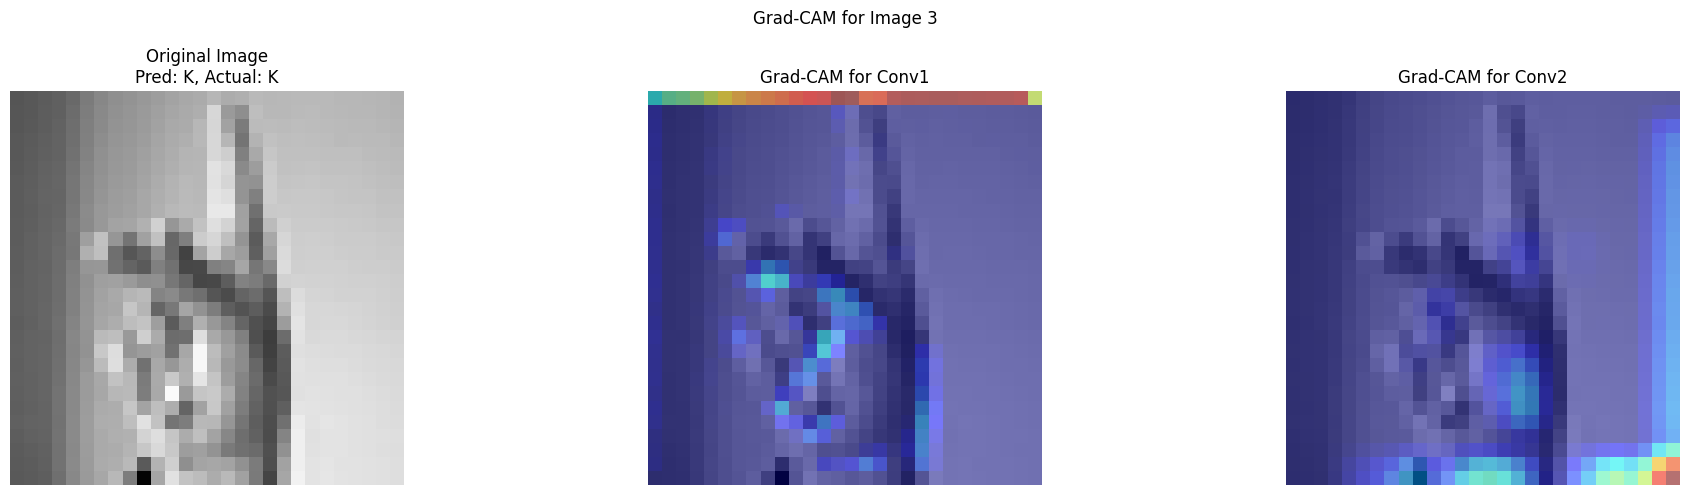

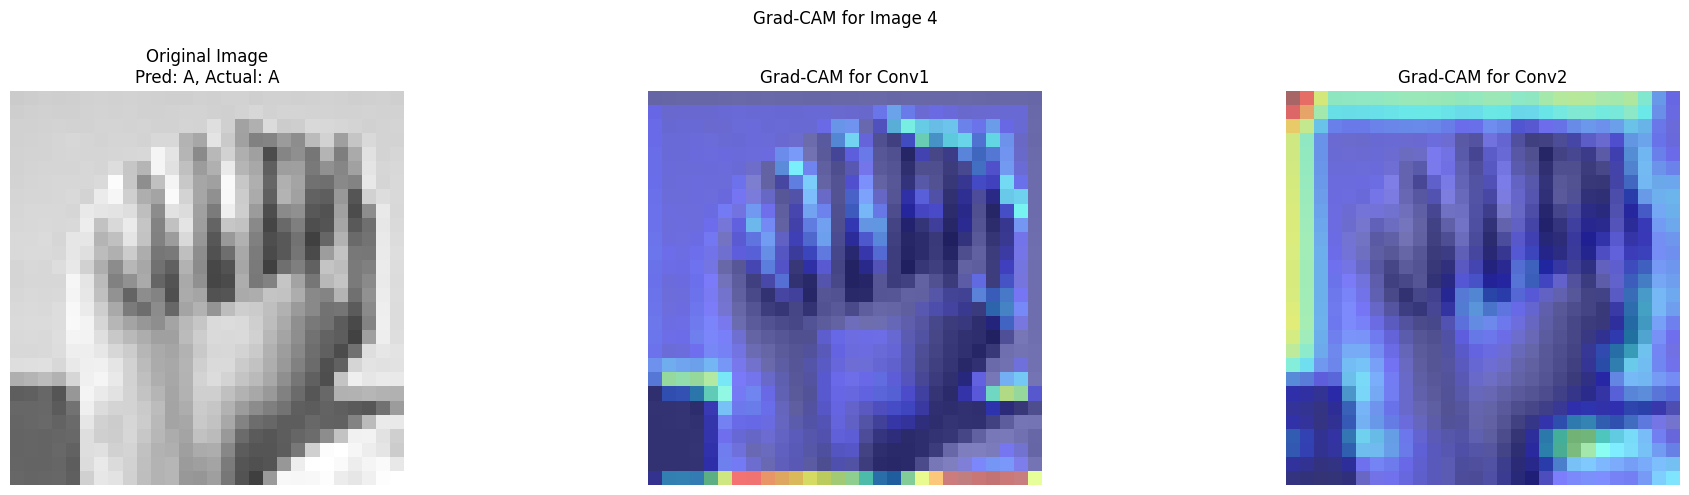

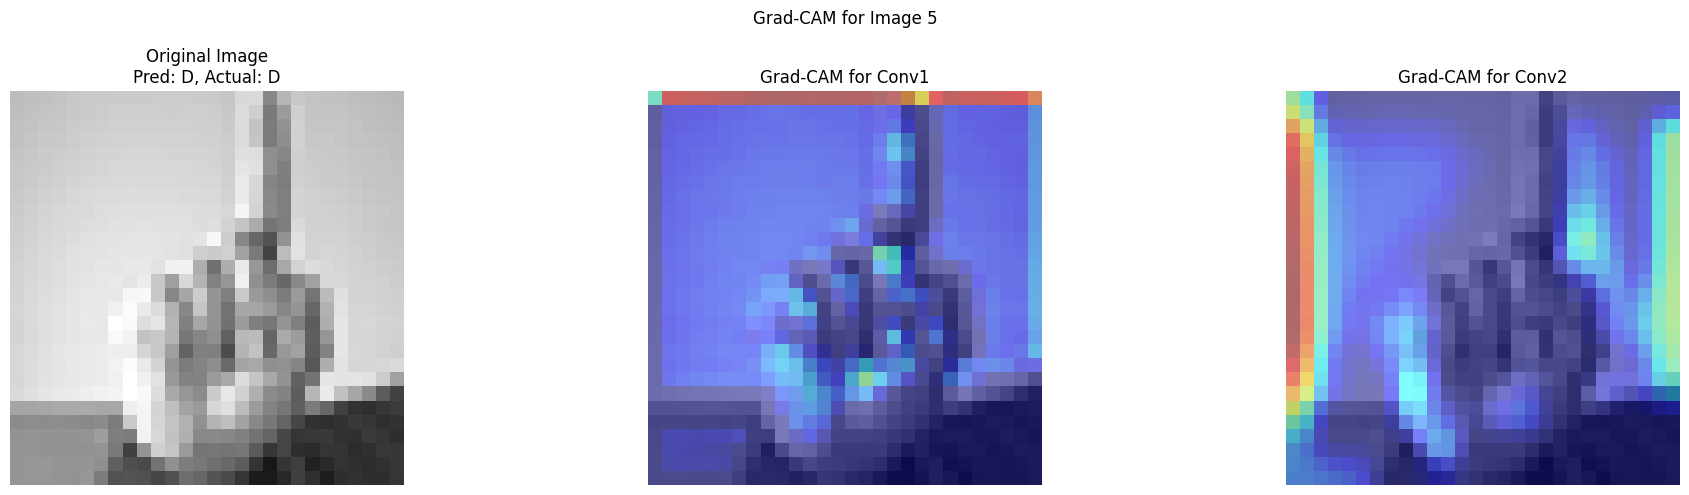

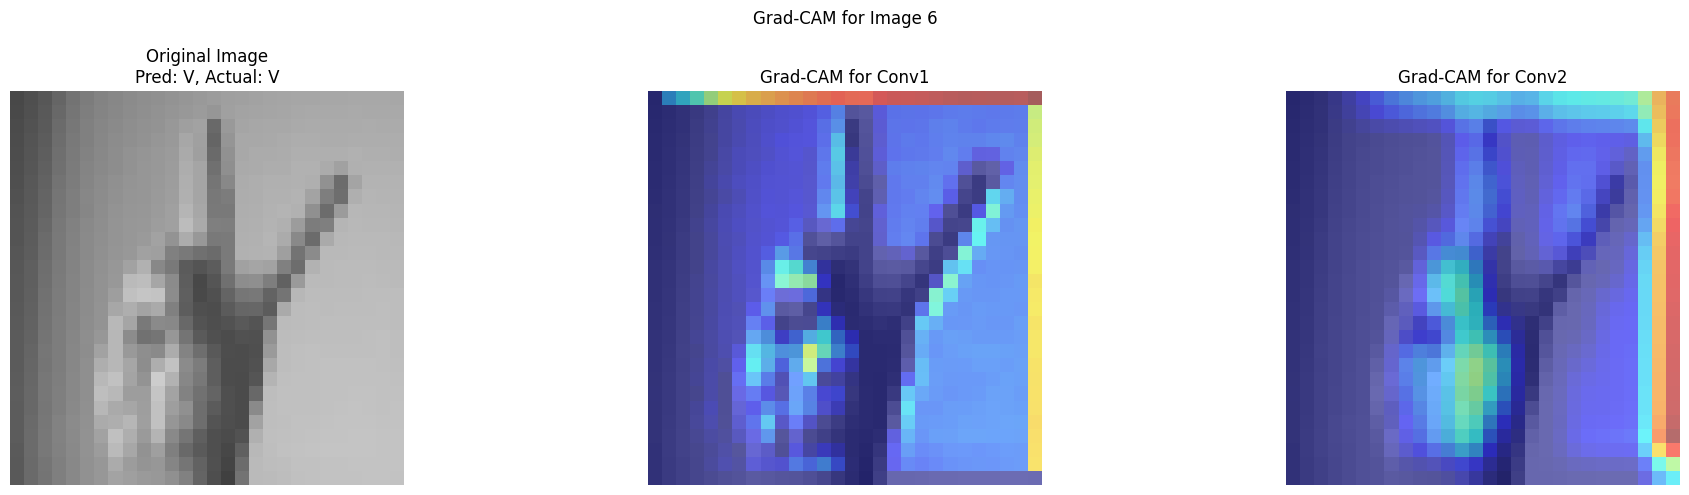

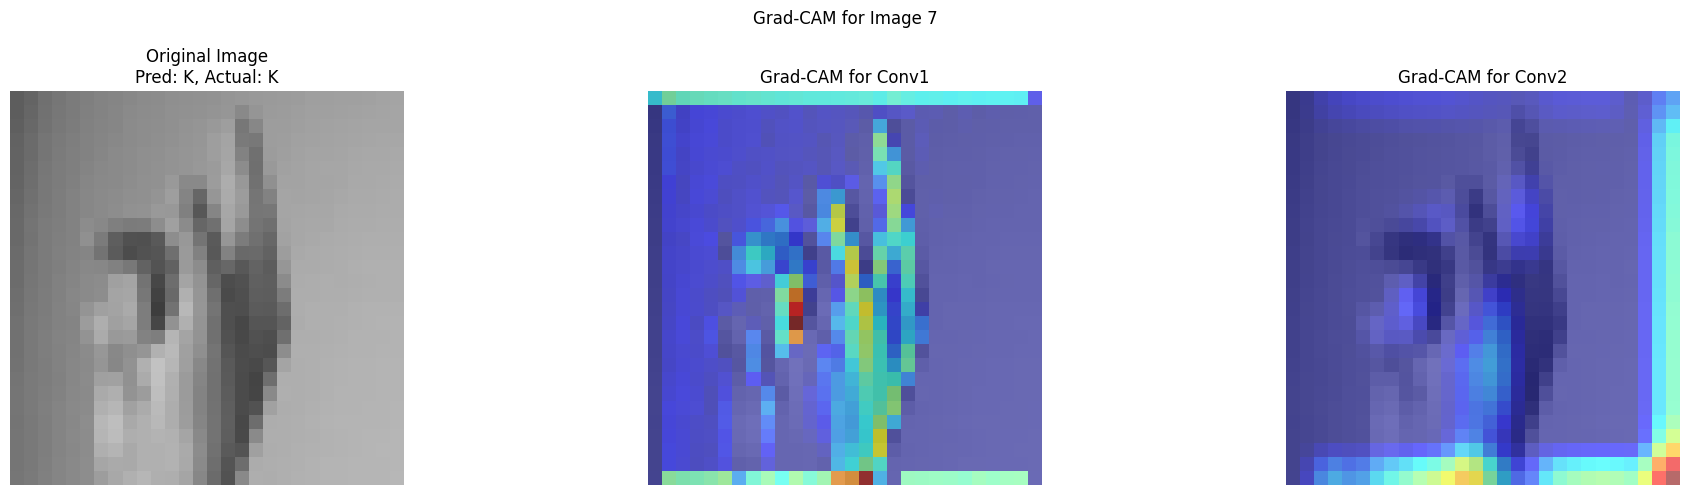

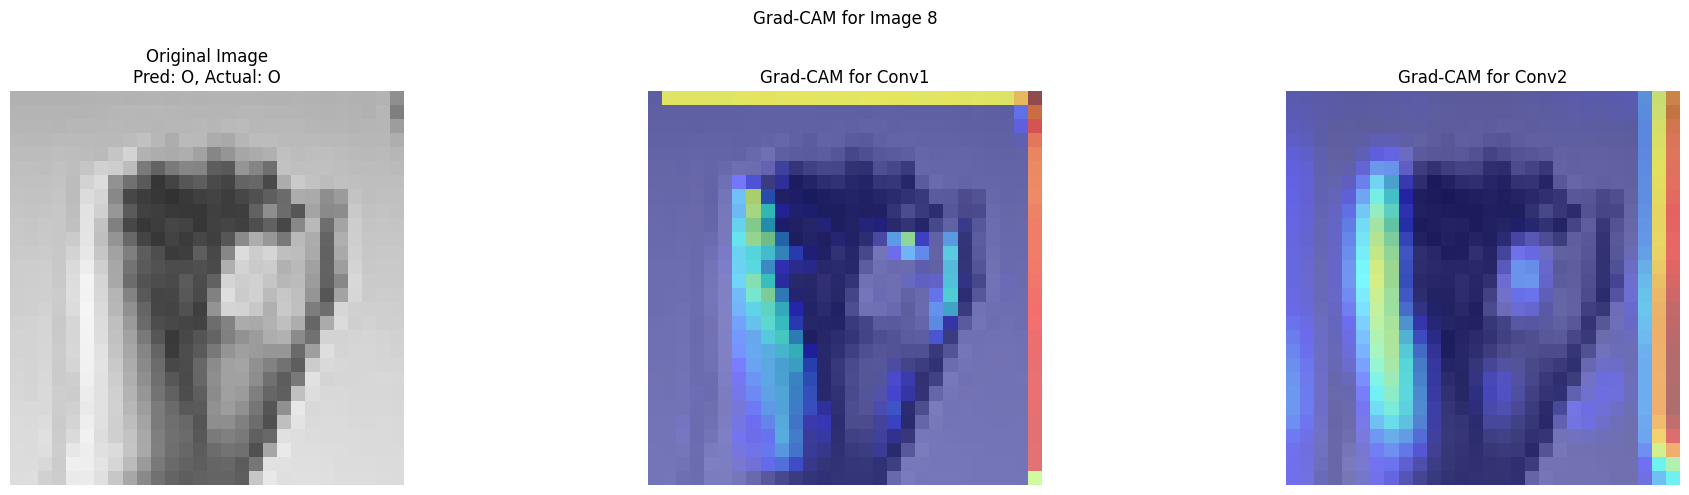

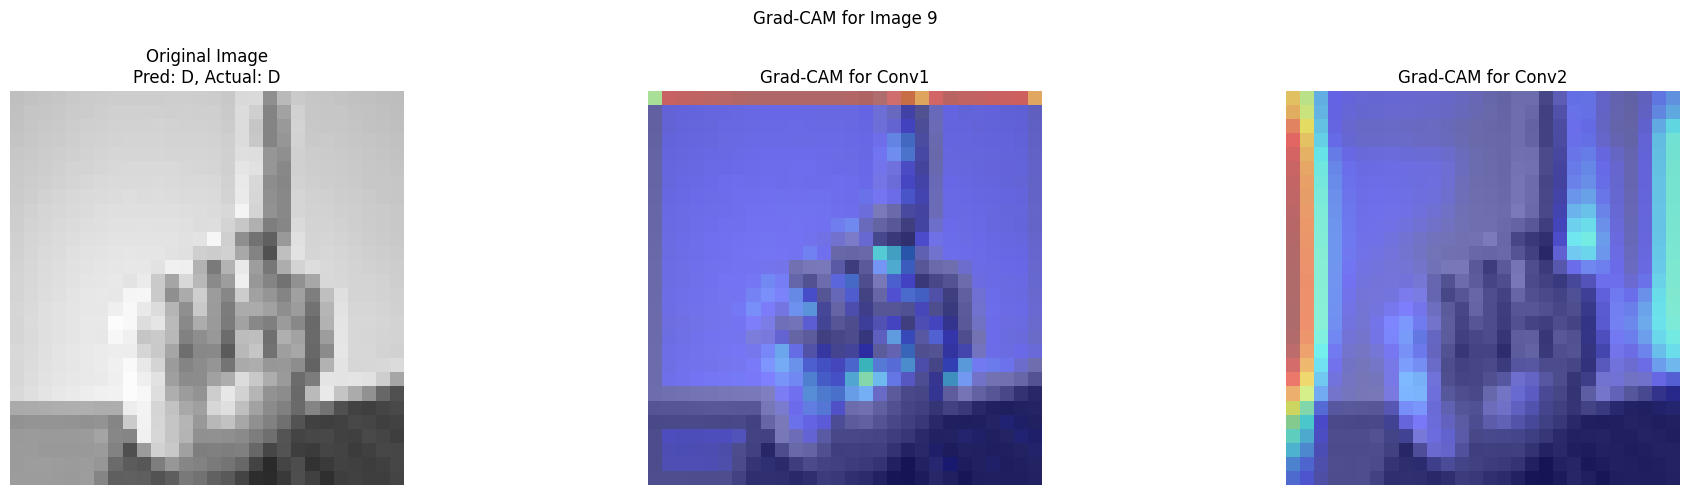

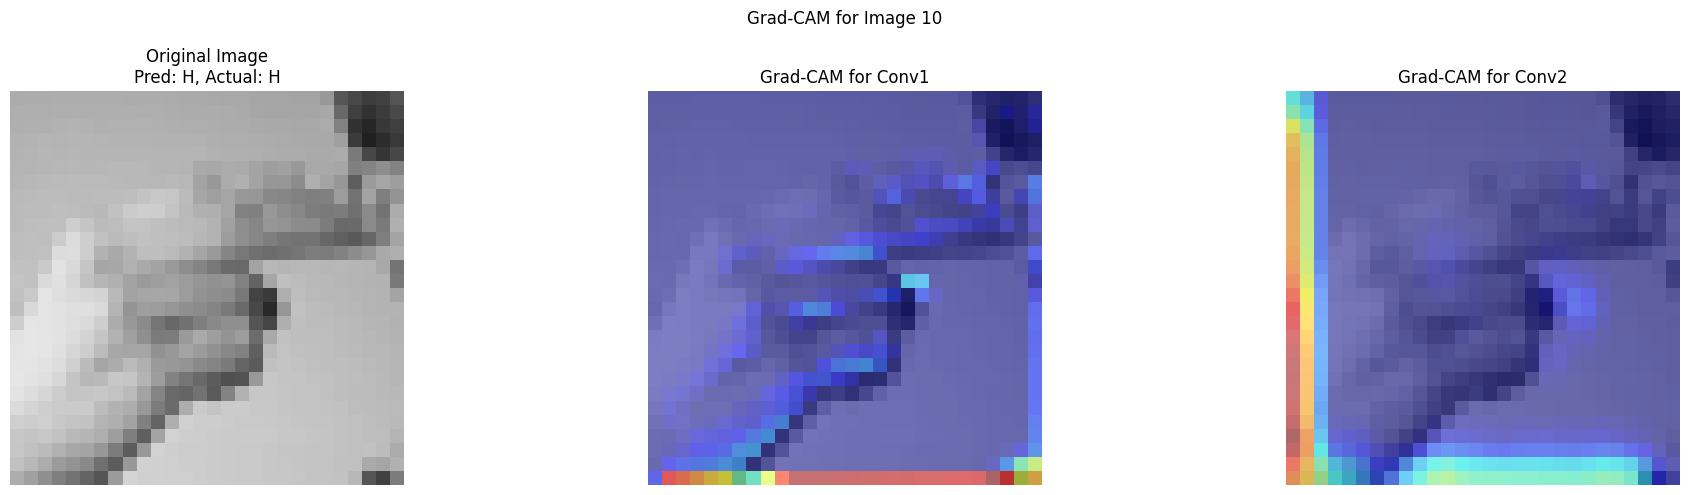

In [9]:
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import cv2

# target layers for Grad-CAM
target_layers = [layer for layer in model.modules() if isinstance(layer, nn.Conv2d)]

for img_idx in range(10):
    sample_img, sample_label = dataset_test[img_idx]
    sample_img = sample_img.unsqueeze(0).to(device)
    sample_img_pil = to_pil_image(sample_img[0].cpu())

    # Get the predicted class
    output = model(sample_img)
    predicted_class = output.argmax().item()

    # Convert the sample image to RGB for overlay
    rgb_image = np.array(to_pil_image(sample_img[0].cpu())).astype(np.float32) / 255.0
    rgb_image = np.stack([rgb_image] * 3, axis=-1)  # Convert grayscale to RGB

    # Set up the figure to display Grad-CAMs for each layer
    fig, axes = plt.subplots(1, len(target_layers) + 1, figsize=(20, 5))
    axes[0].imshow(rgb_image)
    axes[0].set_title(
        f"Original Image\nPred: {labels_map[predicted_class]}, Actual: {labels_map[sample_label.item()]}"
    )
    axes[0].axis("off")

    for idx, layer in enumerate(target_layers):
        cam = GradCAM(model=model, target_layers=[layer])
        grayscale_cam = cam(input_tensor=sample_img, targets=[ClassifierOutputTarget(predicted_class)])[0]

        # Resize the grayscale CAM to match the size of rgb_image
        grayscale_cam_resized = cv2.resize(grayscale_cam, (rgb_image.shape[1], rgb_image.shape[0]))

        # Expand CAM to 3 channels
        grayscale_cam_resized_3ch = np.repeat(grayscale_cam_resized[:, :, np.newaxis], 3, axis=2)

        # Generate overlay
        cam_image = show_cam_on_image(rgb_image, grayscale_cam_resized_3ch, use_rgb=True)

        # Display the CAM
        axes[idx + 1].imshow(cam_image)
        axes[idx + 1].set_title(f"Grad-CAM for Conv{idx + 1}")
        axes[idx + 1].axis("off")

    plt.suptitle(f"Grad-CAM for Image {img_idx + 1}")
    plt.tight_layout()
    plt.show()


## Analyze Performance with Confusion Matrix

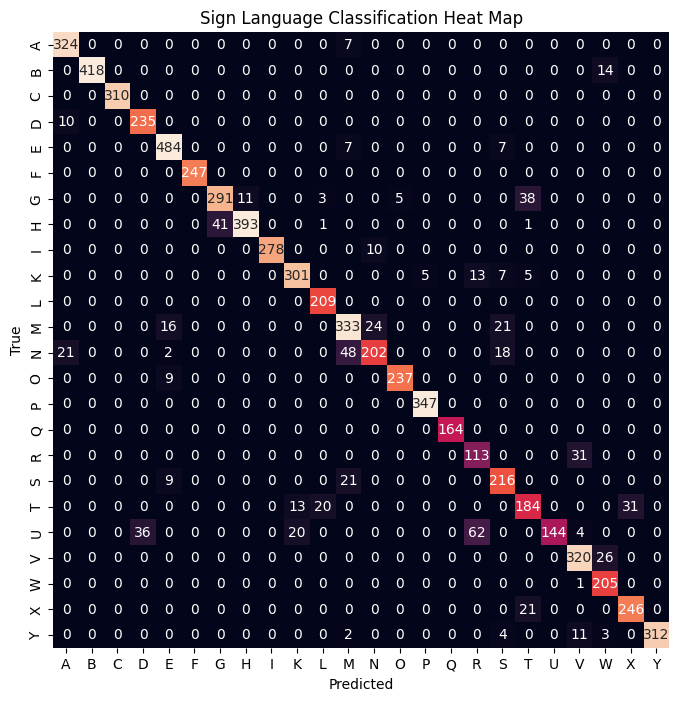

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
cm = confusion_matrix(y_true, y_pred)
model.train()

labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y"]
plt.figure(figsize=(10,8))
sns.heatmap(cm,
            annot=True,
            cbar=False,
            fmt='d',
            square=True,
            vmin=0,
            vmax=0.7*np.max(cm),
            xticklabels=labels,
            yticklabels=labels
)
plt.title("Sign Language Classification Heat Map")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Evaluating the confusion matrix
The confusion matrix offers the following results:
- The model farely often confuses `U` or `K` with `R` and `T` with `G`
- A lot of mislabeling of the CNN corresponds to big similarities for the human eye, too (`U` and `R`, `K` and `R`, `H` and `G`, and so forth)

The confustion matrix can be further understood by taking a closer look at the number of occurrences of each letter in the data: 

[331, 432, 310, 245, 498, 247, 348, 436, 288, 0, 331, 209, 394, 291, 246, 347, 164, 144, 246, 248, 266, 346, 206, 267, 332, 0]


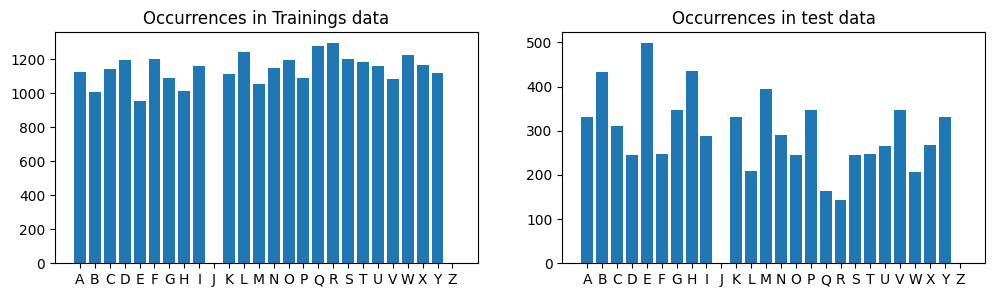

In [11]:
allLetters = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
test_occurrences = [0]*26
train_occurrences = [0]*26
for _, test_labels in test_loader:
    for label in test_labels:
        test_occurrences[label]+=1
for _, train_labels in train_loader:
    for label in train_labels:
        train_occurrences[label]+=1

plt.figure(figsize=(12,3))
plt.subplot(121)
plt.title("Occurrences in Trainings data")
plt.bar(allLetters, train_occurrences)
plt.subplot(122)
plt.title("Occurrences in test data")
print(test_occurrences)
plt.bar(allLetters, test_occurrences)
plt.show()


- Whilst the letter `R` is the most frequent letter in the trainings data, it is the rarest in the test data. This explains the overconfidence regarding this letter. 
- The right bar plot also brings clarity to the bright spots on the confusion matrix's diagonal line: The 4 brightest samples (`E`, `H`, `M`, `P`) are part of the 5 most frequent letters in the test data set, not necessarily the ones performing the best (i.e. see `N` and `S` being confused with `E`)
- Note `J` and `Z` are missing as they are moving signs 